Workflow

1. Train a U-Net model to generate soft masks (no hard thresholding).
2. U-Net trained to reconstruct mean grayscale structure of input images.
3. Apply soft masks to original RGB images during training.
4. Train a separate ResNet18-based classifier using masked images.
5. Perform binary classification (normal vs abnormal tissue).
6. Monitor loss and accuracy per epoch; no AUC emphasized due to small batches and binary setup.

Goal: Use U-Net masks to guide the classifier to focus on more meaningful regions and improve detection of abnormalities.

# UNet trained on downscaled versions of the original histology patches   

In [12]:
import os
import glob
import random
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Set base directory
base_dir = "/gpfs/scratch/hz3106/Gashisdb/Gashisdb_processed/120x120"   

# Set seed for reproducibility
random.seed(42)

# Gather all image paths and labels
normal_paths = sorted(glob.glob(os.path.join(base_dir, "normal", "*.png")))
abnormal_paths = sorted(glob.glob(os.path.join(base_dir, "abnormal", "*.png")))

normal_labels = [0] * len(normal_paths)
abnormal_labels = [1] * len(abnormal_paths)

all_paths = normal_paths + abnormal_paths
all_labels = normal_labels + abnormal_labels

# Shuffle together
combined = list(zip(all_paths, all_labels))
random.shuffle(combined)
all_paths, all_labels = zip(*combined)

# Split 75-15-15
total_samples = len(all_paths)
train_size = int(0.75 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size

train_paths = all_paths[:train_size]
train_labels = all_labels[:train_size]

val_paths = all_paths[train_size:train_size+val_size]
val_labels = all_labels[train_size:train_size+val_size]

test_paths = all_paths[train_size+val_size:]
test_labels = all_labels[train_size+val_size:]

print(f"Train: {len(train_paths)}, Val: {len(val_paths)}, Test: {len(test_paths)}")


Train: 110202, Val: 22040, Test: 14695


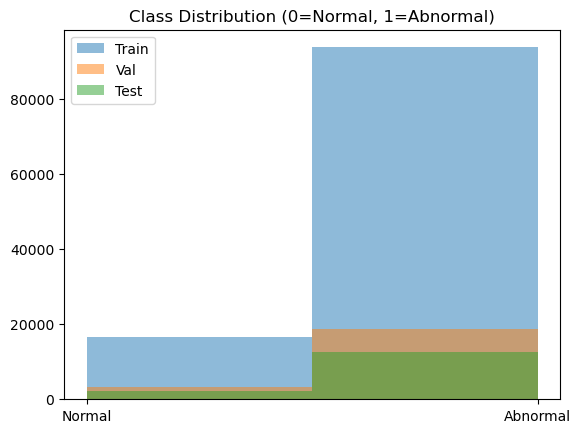

In [5]:
import matplotlib.pyplot as plt

# Plot class balance
plt.hist(train_labels, bins=2, alpha=0.5, label='Train')
plt.hist(val_labels, bins=2, alpha=0.5, label='Val')
plt.hist(test_labels, bins=2, alpha=0.5, label='Test')
plt.xticks([0, 1], ['Normal', 'Abnormal'])
plt.legend()
plt.title("Class Distribution (0=Normal, 1=Abnormal)")
plt.show()

Abnormal is much more than normal 

In [13]:
# Total number of samples per class (only on TRAINING set)
num_normal = sum([1 for label in train_labels if label == 0])
num_abnormal = sum([1 for label in train_labels if label == 1])

# Inverse frequency weighting
weight_normal = 1.0 / num_normal
weight_abnormal = 1.0 / num_abnormal

class_weights = torch.tensor([weight_normal, weight_abnormal], dtype=torch.float).to(device)

print(f"Class Weights: {class_weights}")

Class Weights: tensor([6.0724e-05, 1.0668e-05], device='cuda:0')


In [18]:
# Define Dataset
class HistologyDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label  # return image and label

# Image transformations
img_size = 120
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

# Create datasets
train_dataset = HistologyDataset(train_paths, train_labels, transform=transform)
val_dataset = HistologyDataset(val_paths, val_labels, transform=transform)
test_dataset = HistologyDataset(test_paths, test_labels, transform=transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Defines, trains, and saves a simple U-Net model for unsupervised autoencoder-style reconstruction learning.

- The U-Net architecture consists of an encoder-decoder structure with skip connections between layers of the same spatial size.
- In this setup, the U-Net is trained to **reconstruct the original RGB input images** directly, not to predict segmentation masks or gray-scale versions.
    - For each input image, the U-Net output tries to match the full RGB image (3 channels), learning to capture important structural features without supervision.
- The loss is computed as the **Mean Squared Error (MSE) between the U-Net's output and the original input images**.
    - MSELoss is more appropriate here because we're asking our U-Net to simply reconstruct the appearance of input images (or simplified images), not to output sharp foreground/background segmentation.
- Training proceeds for 20 epochs on the dataset split into training and validation sets, tracking both training and validation reconstruction loss.
- After training, the U-Net model weights are saved for later use (e.g., for masking images before classification).

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define simple UNet
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=3):
        super().__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))

        self.up1 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv1 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv3 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)

        x = self.up1(x4)
        x = torch.cat([x, x3], dim=1)
        x = self.conv1(x)

        x = self.up2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.conv2(x)

        x = self.up3(x)
        x = torch.cat([x, x1], dim=1)
        x = self.conv3(x)

        logits = self.final(x)
        return logits


Epoch 1/20 | Train Loss: 0.0108 | Val Loss: 0.0002
Epoch 2/20 | Train Loss: 0.0002 | Val Loss: 0.0001
Epoch 3/20 | Train Loss: 0.0001 | Val Loss: 0.0000
Epoch 4/20 | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch 5/20 | Train Loss: 0.0001 | Val Loss: 0.0001
Epoch 6/20 | Train Loss: 0.0001 | Val Loss: 0.0000
Epoch 7/20 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 8/20 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 9/20 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 10/20 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 11/20 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 12/20 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 13/20 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 14/20 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 15/20 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 16/20 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 17/20 | Train Loss: 0.0000 | Val Loss: 0.0001
Epoch 18/20 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 19/20 | Train Loss: 0.0000 | Val Loss: 0.0000
Epoch 20/20 | Train L

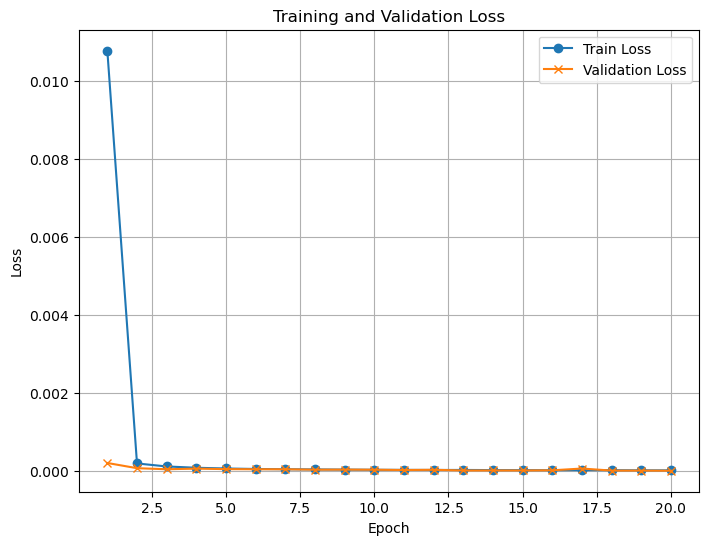

In [11]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = UNet().to(device)
optimizer = optim.Adam(unet.parameters(), lr=1e-4)
criterion = nn.MSELoss()

num_epochs = 20
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    unet.train()
    running_train_loss = 0.0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        preds = unet(imgs)
        loss = criterion(preds, imgs)   # <<< FIXED HERE (use imgs, not imgs.mean)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
    train_loss_epoch = running_train_loss / len(train_loader)
    train_losses.append(train_loss_epoch)

    # Validation
    unet.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for imgs, _ in val_loader:
            imgs = imgs.to(device)
            preds = unet(imgs)
            val_loss = criterion(preds, imgs)   # use imgs, not imgs.mean
            running_val_loss += val_loss.item()
    val_loss_epoch = running_val_loss / len(val_loader)
    val_losses.append(val_loss_epoch)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss_epoch:.4f} | Val Loss: {val_loss_epoch:.4f}")

# Save model
torch.save(unet.state_dict(), "./unet_gastric_segmentation_updated.pth")

# Plot losses
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Instantiate model
unet = UNet(n_channels=3, n_classes=3)

# Load model weights with proper device mapping
state_dict = torch.load("/gpfs/scratch/sc11601/DL_projects/jupyter_gpu/unet_gastric_segmentation_updated.pth", map_location=device)

unet.load_state_dict(state_dict)
unet.to(device)
unet.eval()

print("Model loaded on", device)

Using device: cuda
Model loaded on cuda


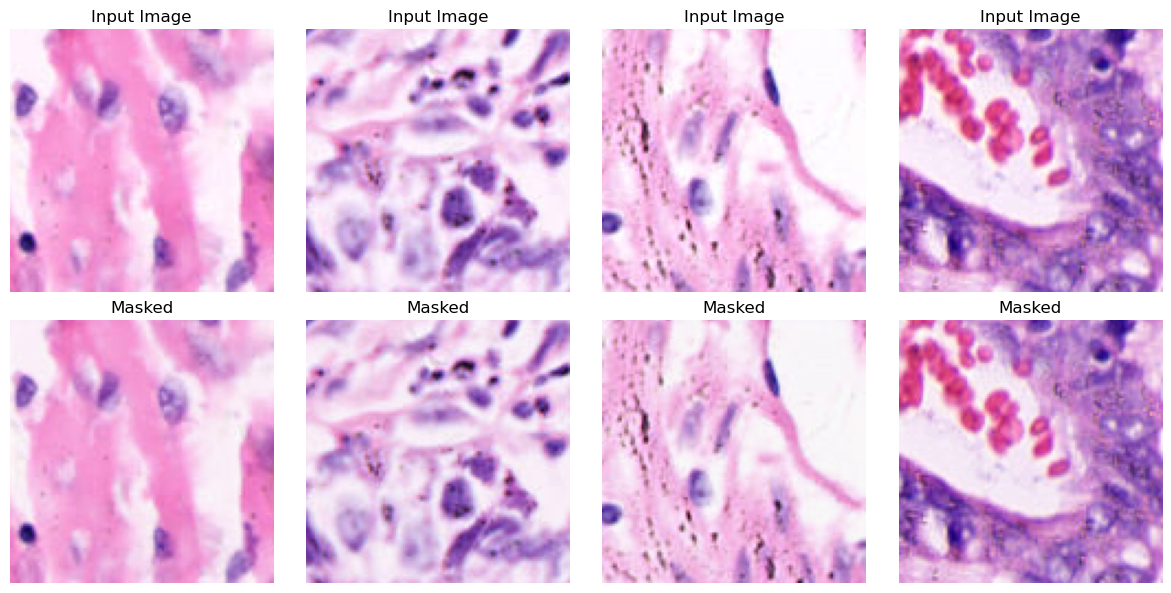

In [10]:
import matplotlib.pyplot as plt
import torch

# Set model to evaluation mode
unet.eval()

# Load a batch from validation set
imgs, _ = next(iter(val_loader))
imgs = imgs.to(device)

# Predict masks
with torch.no_grad():
    preds = unet(imgs)                   # Raw UNet outputs
    preds = torch.sigmoid(preds)          # Apply sigmoid to get soft masks[0,1] soft masks
    preds = preds
    # preds = (preds > 0.5).float()          # Binarize into 0 or 1

# Move to CPU for plotting
imgs = imgs.cpu()
preds = preds.cpu()

# Plot Input Images vs Predicted RGB Masks
n = 4  # Number of examples you want to plot
plt.figure(figsize=(12, 6))
for i in range(n):
    # Plot original input image
    plt.subplot(2, n, i + 1)
    img = imgs[i].permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
    plt.imshow(img)
    plt.axis('off')
    plt.title('Input Image')

    # Plot predicted RGB mask
    plt.subplot(2, n, n + i + 1)
    mask = preds[i].permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)
    mask = (mask - mask.min()) / (mask.max() - mask.min())  # Normalize for display
    plt.imshow(mask)
    plt.axis('off')
    plt.title('Masked')

plt.tight_layout()
plt.show()

Top: original histopathology input image (normalized)
Bottom: the U-Net predicted soft mask (grayscale, values 0 to 1)

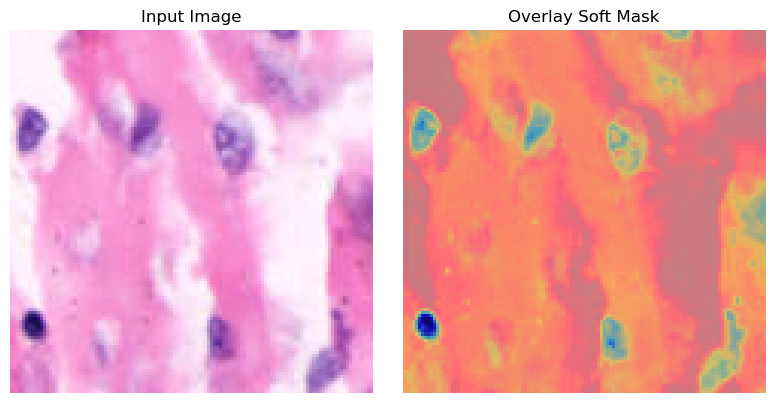

In [13]:
###### Overlay Soft Mask on Image###
# Pick one example
idx = 0

# Input image (normalize for display)
input_img = imgs[idx].permute(1, 2, 0).cpu().numpy()
input_img = (input_img - input_img.min()) / (input_img.max() - input_img.min())

# Soft mask = average across RGB channels
mask = preds[idx].mean(0).cpu().numpy()  # <<<< THIS LINE IS UPDATED
mask = (mask - mask.min()) / (mask.max() - mask.min())  # Optional: normalize mask too

plt.figure(figsize=(8,4))

# Input image
plt.subplot(1, 2, 1)
plt.imshow(input_img)
plt.axis('off')
plt.title('Input Image')

# Overlayed
plt.subplot(1, 2, 2)
plt.imshow(input_img)
plt.imshow(mask, cmap='jet', alpha=0.5)  # soft mask overlay
plt.axis('off')
plt.title('Overlay Soft Mask')

plt.tight_layout()
plt.show()

In [14]:
print(f"Predicted mask min value: {preds.min().item():.4f}")
print(f"Predicted mask max value: {preds.max().item():.4f}")

Predicted mask min value: 0.5401
Predicted mask max value: 0.7360


In [15]:
for i in range(preds.shape[0]):  # Loop over batch
    print(f"Image {i}: Min={preds[i].min().item():.4f}, Max={preds[i].max().item():.4f}")

Image 0: Min=0.5583, Max=0.7338
Image 1: Min=0.5482, Max=0.7342
Image 2: Min=0.5585, Max=0.7345
Image 3: Min=0.5562, Max=0.7343
Image 4: Min=0.5685, Max=0.7332
Image 5: Min=0.5515, Max=0.7344
Image 6: Min=0.5637, Max=0.7344
Image 7: Min=0.5600, Max=0.7343
Image 8: Min=0.5435, Max=0.7350
Image 9: Min=0.5422, Max=0.7325
Image 10: Min=0.5448, Max=0.7344
Image 11: Min=0.5402, Max=0.7341
Image 12: Min=0.5454, Max=0.7331
Image 13: Min=0.5540, Max=0.7343
Image 14: Min=0.5762, Max=0.7347
Image 15: Min=0.5814, Max=0.7360
Image 16: Min=0.5412, Max=0.7345
Image 17: Min=0.5603, Max=0.7338
Image 18: Min=0.5410, Max=0.7333
Image 19: Min=0.5605, Max=0.7343
Image 20: Min=0.5674, Max=0.7308
Image 21: Min=0.5446, Max=0.7347
Image 22: Min=0.5468, Max=0.7331
Image 23: Min=0.5440, Max=0.7351
Image 24: Min=0.5565, Max=0.7339
Image 25: Min=0.5487, Max=0.7352
Image 26: Min=0.5963, Max=0.7323
Image 27: Min=0.5494, Max=0.7347
Image 28: Min=0.5495, Max=0.7338
Image 29: Min=0.5468, Max=0.7330
Image 30: Min=0.5401

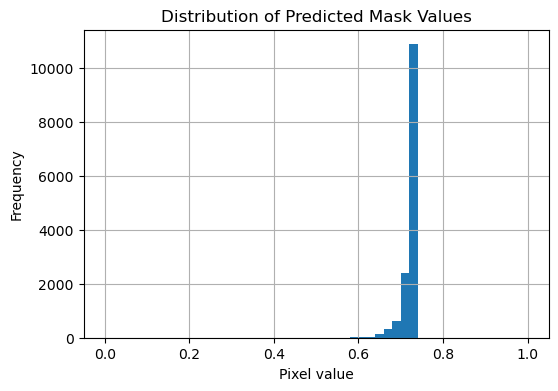

In [17]:
import matplotlib.pyplot as plt

# Assuming preds is [batch_size, 1, H, W]
pred_sample = preds[0, 0].detach().cpu().numpy()  # Pick first sample

# Plot histogram
plt.figure(figsize=(6, 4))
plt.hist(pred_sample.flatten(), bins=50, range=(0,1))
plt.title("Distribution of Predicted Mask Values")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.grid()
plt.show()

imgs shape: torch.Size([8, 3, 120, 120])
preds shape: torch.Size([8, 1, 120, 120])
Image 0: Min=0.4897, Max=0.4939
Image 1: Min=0.4898, Max=0.4941
Image 2: Min=0.4898, Max=0.4940
Image 3: Min=0.4897, Max=0.4940


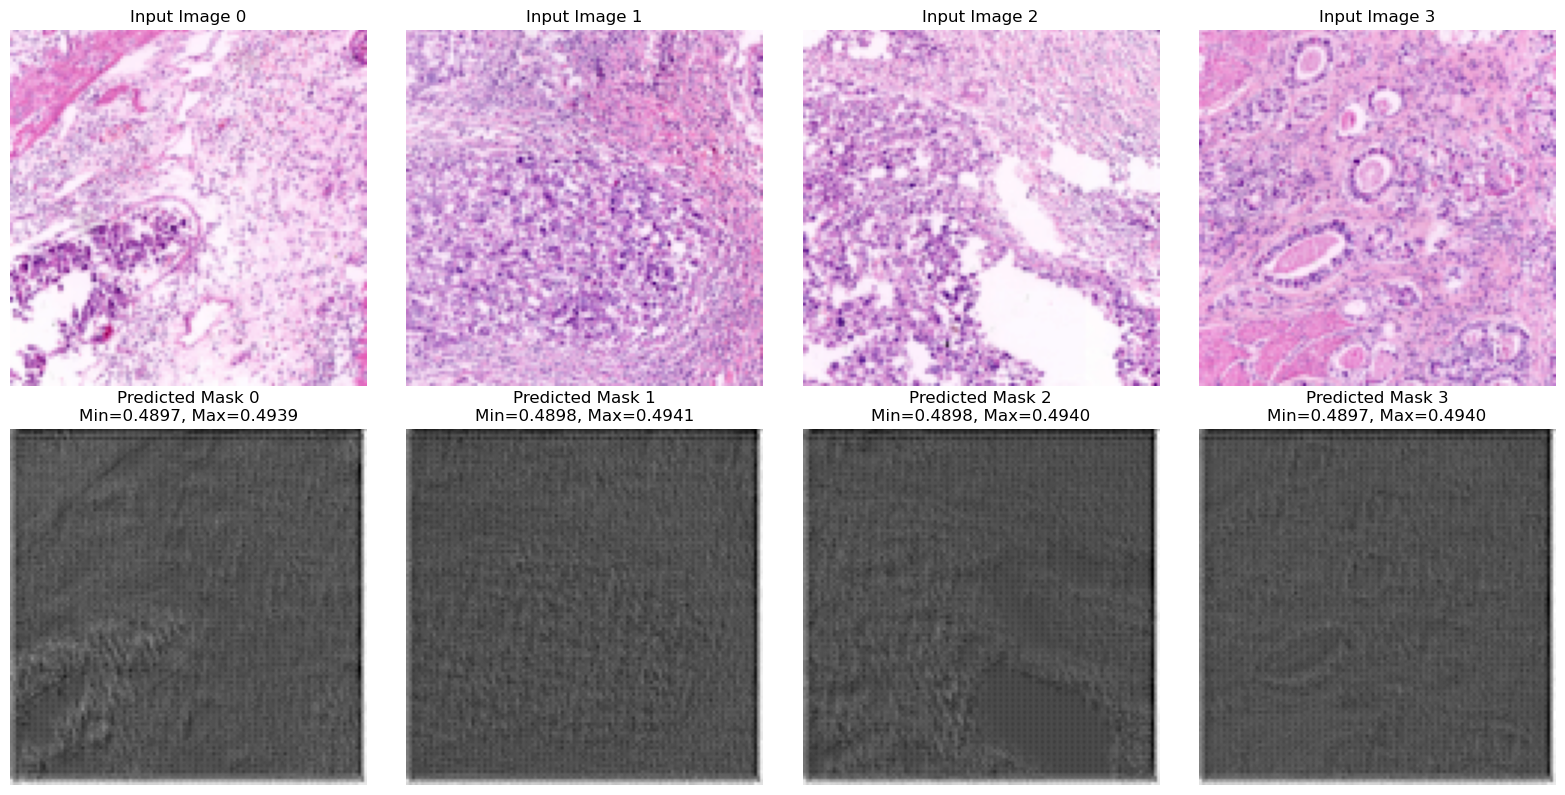

In [33]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Set model to eval mode and get predictions
unet.eval()
imgs, _ = next(iter(val_loader))
imgs = imgs.to(device)

with torch.no_grad():
    preds = unet(imgs)
    preds = torch.sigmoid(preds)

# Move to CPU for plotting
imgs = imgs.cpu()
preds = preds.cpu()

# Check shapes
print(f"imgs shape: {imgs.shape}")    # Should be [B, 3, H, W]
print(f"preds shape: {preds.shape}")  # Should be [B, 1, H, W]

# Plot input images and predicted masks
n = min(4, len(imgs))
fig, axes = plt.subplots(2, n, figsize=(4 * n, 8))

for i in range(n):
    # Input image
    img = imgs[i].permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())

    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Input Image {i}")
    axes[0, i].axis('off')

    # Predicted mask (first channel only)
    mask = preds[i][0].numpy()
    mask_norm = (mask - mask.min()) / (mask.max() - mask.min())
    min_val, max_val = mask.min(), mask.max()

    axes[1, i].imshow(mask_norm, cmap='gray')
    axes[1, i].set_title(f"Predicted Mask {i}\nMin={min_val:.4f}, Max={max_val:.4f}")
    axes[1, i].axis('off')

    print(f"Image {i}: Min={min_val:.4f}, Max={max_val:.4f}")

plt.tight_layout()
plt.show()

# Basic ResNet18 (gastric_cnn_resnet.pth)

In [35]:
def create_basic_resnet_model(num_classes=2):
    model = models.resnet18(pretrained=True)
    
    # Freeze all backbone
    for param in model.parameters():
        param.requires_grad = False
    
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model

classifier_basic = create_basic_resnet_model(num_classes=2).to(device)
classifier_basic.load_state_dict(torch.load("/gpfs/scratch/hz3106/Gashisdb/models/gastric_cnn_resnet.pth"))
classifier_basic.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Gradual ResNet

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [20]:
def create_gradual_fc_resnet_model(num_classes=2):
    model = models.resnet18(pretrained=True)
    for param in list(model.parameters())[:-30]:
        param.requires_grad = False
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_ftrs, 2048),
        nn.BatchNorm1d(2048),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(2048, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(1024, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.Linear(256, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Linear(64, 32),
        nn.BatchNorm1d(32),
        nn.ReLU(inplace=True),
        nn.Dropout(0.2),
        nn.Linear(32, num_classes)
    )
    return model

class GasHisSDBDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['normal', 'abnormal']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        
        self.samples = []
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                    self.samples.append((
                        os.path.join(class_dir, img_name),  # <-- save image path
                        self.class_to_idx[class_name]
                    ))

    def __getitem__(self, idx):
        img_path, _ = self.samples[idx]  # ignore the label!
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_path  # return img_path (string)

In [24]:
from torchvision import models

# Load Unet
unet = UNet().to(device)
unet.load_state_dict(torch.load("/gpfs/scratch/sc11601/DL_projects/jupyter_gpu/unet_gastric_segmentation_updated.pth"))
unet.eval()

# LOAD CLASSIFIER 
classifier = create_gradual_fc_resnet_model(num_classes=2).to(device)
classifier.load_state_dict(torch.load("/gpfs/scratch/hz3106/Gashisdb/models/gradual_fc_gastric_cnn_resnet.pth"))
classifier.eval()

/gpfs/data/davolilab/projects/melanoma_scrna/ENTER/envs/dl4med_25/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/gpfs/data/davolilab/projects/melanoma_scrna/ENTER/envs/dl4med_25/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
# Define dataloaders 
class PathBasedDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, img_path  # return path, not label

train_dataset = PathBasedDataset(train_paths, transform=transform)
val_dataset = PathBasedDataset(val_paths, transform=transform)
test_dataset = PathBasedDataset(test_paths, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [25]:
import torch.optim as optim
import torch.nn as nn

# Set optimizer and loss 
optimizer_cls = optim.Adam(classifier.parameters(), lr=1e-4)
criterion_cls = nn.CrossEntropyLoss(weight=class_weights.to(device)) 

# === Functions for train and validation ===
def train_step(loader, classifier, unet, optimizer, criterion):
    classifier.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for imgs, img_paths in loader:
        imgs = imgs.to(device)
        labels = []
        for path in img_paths:
            path_str = str(path)  # path might be a Path object or Tensor, make sure it's string
            if 'normal' in path.lower():
                labels.append(0)
            else:
                labels.append(1)
        labels = torch.tensor(labels, dtype=torch.long).to(device)

        with torch.no_grad():
            masks = torch.sigmoid(unet(imgs))
        masked_imgs = imgs * masks

        outputs = classifier(masked_imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        running_loss += loss.item() * imgs.size(0)
        running_corrects += (preds == labels).sum().item()
        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples
    return epoch_loss, epoch_acc


def val_step(loader, classifier, unet, criterion):
    classifier.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for imgs, img_paths in loader:
            imgs = imgs.to(device)
            labels = []
            for path in img_paths:
                if 'non_cancer' in path.lower() or 'normal' in path.lower():
                    labels.append(0)
                else:
                    labels.append(1)
            labels = torch.tensor(labels, dtype=torch.long).to(device)

            masks = torch.sigmoid(unet(imgs))
            masks = (masks > 0.5).float() 
            masked_imgs = imgs * masks

            outputs = classifier(masked_imgs)
            loss = criterion(outputs, labels)

            preds = outputs.argmax(dim=1)
            running_loss += loss.item() * imgs.size(0)
            running_corrects += (preds == labels).sum().item()
            total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples
    return epoch_loss, epoch_acc


# === Training Loop ===
num_epochs_cls = 20
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(num_epochs_cls):
    print(f"\nEpoch {epoch+1}/{num_epochs_cls}")
    print('-' * 30)

    train_loss, train_acc = train_step(train_loader, classifier, unet, optimizer_cls, criterion_cls)
    val_loss, val_acc = val_step(val_loader, classifier, unet, criterion_cls)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

# === Save the trained masked classifier ===
torch.save(classifier.state_dict(), "./classifier_masked_downscaled.pth")
print("\nMasked classifier training completed and saved!")


# === Plot Loss and Accuracy ===
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()



Epoch 1/20
------------------------------


KeyboardInterrupt: 

In [ ]:
import torch

# === Simple test function ===
def test_step(loader, classifier, unet, criterion):
    classifier.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for imgs, img_paths in loader:
            imgs = imgs.to(device)
            labels = []
            for path in img_paths:
                path_str = str(path)
                if 'non_cancer' in path_str.lower() or 'normal' in path_str.lower():
                    labels.append(0)
                else:
                    labels.append(1)
            labels = torch.tensor(labels, dtype=torch.long).to(device)

            masks = torch.sigmoid(unet(imgs))
            masked_imgs = imgs * masks

            outputs = classifier(masked_imgs)
            loss = criterion(outputs, labels)

            preds = outputs.argmax(dim=1)
            running_loss += loss.item() * imgs.size(0)
            running_corrects += (preds == labels).sum().item()
            total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples
    return epoch_loss, epoch_acc

# === Test on test set ===
test_loss, test_acc = test_step(test_loader, classifier, unet, criterion_cls)

print(f"\nTEST SET RESULTS:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

In [48]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# === Initialize history ===
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}
    
# === Training masked classifier ===
num_epochs_cls = 20

for epoch in range(num_epochs_cls):
    print(f"\nEpoch {epoch+1}/{num_epochs_cls}")
    print('-' * 30)
    
    for phase in ['train', 'val']:
        if phase == 'train':
            classifier.train()
            dataloader = train_loader
        else:
            classifier.eval()
            dataloader = val_loader

        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for imgs, img_paths in dataloader:
            imgs = imgs.to(device)

            # Make labels based on paths
            labels = []
            for path in img_paths:
                if 'non_cancer' in path.lower() or 'normal' in path.lower():
                    labels.append(0)
                else:
                    labels.append(1)
            labels = torch.tensor(labels, dtype=torch.long).to(device)

            # Generate masks
            with torch.no_grad():
                masks = torch.sigmoid(unet(imgs))

            # Masked images
            masked_imgs = imgs * masks

            # Classifier forward
            outputs = classifier(masked_imgs)
            loss = criterion_cls(outputs, labels)

            if phase == 'train':
                optimizer_cls.zero_grad()
                loss.backward()
                optimizer_cls.step()

            preds = outputs.argmax(dim=1)
            running_loss += loss.item() * imgs.size(0)
            running_corrects += (preds == labels).sum().item()
            total_samples += labels.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects / total_samples

        print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
        history[f'{phase}_loss'].append(epoch_loss)
        history[f'{phase}_acc'].append(epoch_acc)

# Save the trained masked classifier
torch.save(classifier.state_dict(), "./classifier_masked_trained.pth")
print("\nMasked classifier training completed and saved!")


Epoch 1/20
------------------------------


AttributeError: 'Tensor' object has no attribute 'lower'